# A ML model designed to generate unique and authentic Italian names!
#### Note that we can use the same code to generate names in **any language** if we have a similar txt file, we will just have to adjust the **alphabet_length** depending on the number of letters of the chosen language.


In [1]:
import torch
import matplotlib.pyplot as plt
from torch.onnx.symbolic_opset9 import tensor
import torch.nn.functional as F

In [2]:
words = open("names ita.txt", "r").read().splitlines()
words[:10]

['abaco',
 'abbondanza',
 'abbondanzia',
 'abbondanzio',
 'abbondazio',
 'abbondia',
 'abbondina',
 'abbondio',
 'abdenago',
 'abdon']

In [3]:
alphabet_length = 36 # this can be changed depending on the language
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi["."] = 0
itos = { i:c for c,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: '¡',
 28: '¨',
 29: '¯',
 30: 'º',
 31: 'Ã',
 32: 'Ë',
 33: 'â',
 34: '˜',
 35: '€',
 0: '.'}

In [4]:
blcok_size = 3
x, y = [], []
for w in words:
    # print(w)
    context = [0] * blcok_size
    for c in w + '.':
        ix = stoi[c]
        x.append(context)
        y.append(ix)
        # print( "".join(itos[i] for i in context) , "---->", c)
        context = context[1:] + [ix]
x = torch.tensor(x)
y = torch.tensor(y)

In [5]:
#the main model is brought to life starting from here
g = torch.Generator().manual_seed(2147483647)
c = torch.randn(alphabet_length,10, requires_grad=True, generator=g)
w1 = torch.randn(30,300,requires_grad=True, generator=g)
b1 = torch.randn(300,requires_grad=True, generator=g)
w2 = torch.randn(300,alphabet_length, requires_grad=True, generator=g)
b2 = torch.randn(alphabet_length, requires_grad=True, generator=g)
params = [w1, b1, w2, b2, c]
num_params = sum(p.nelement() for p in params)
for p in params:
  p.requires_grad = True

In [6]:
block_size = 3 # this is the context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # next context

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([57217, 3]) torch.Size([57217])
torch.Size([7148, 3]) torch.Size([7148])
torch.Size([7166, 3]) torch.Size([7166])


In [7]:
#included
for i in range(50000): 
  ix = torch.randint(0, Xtr.shape[0], (32,))

  emb = c[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, 30) @ w1 + b1) 
  logits = h @ w2 + b2 
  loss = F.cross_entropy(logits, Ytr[ix])
  
  for p in params:
    p.grad = None
  loss.backward()
  
  lr = 0.1 if i < 40000 else 0.01
  # lr = 0.05
  for p in params:
    p.data += -lr * p.grad


In [8]:
emb = c[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.7092, grad_fn=<NllLossBackward0>)

In [9]:
emb = c[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.8712, grad_fn=<NllLossBackward0>)

## Character Embeddings Visualization

This 2D scatter plot visualizes the learned character embeddings from the model. Each point represents a character, and its position reflects the first two dimensions of its embedding vector. Characters closer together in the plot have similar embeddings, indicating they behave **similarly** in the context of **Italian names**. The plot helps reveal **patterns and relationships** between characters, such as clusters of vowels or consonants, and provides insights into how the model represents linguistic features.

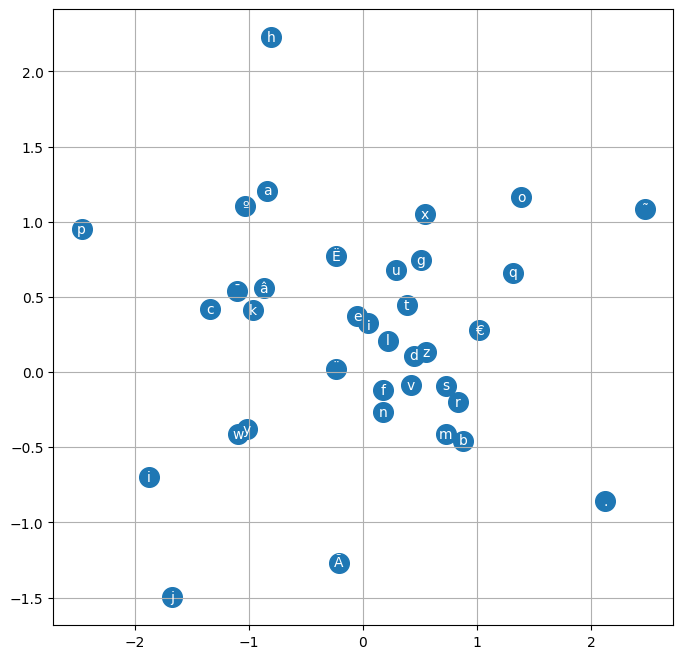

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data, c[:,1].data, s=200)
for i in range(c.shape[0]):
    plt.text(c[i,0].item(), c[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [11]:
g = torch.Generator().manual_seed(2147483645)
generated_names = []
for _ in range(10000):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = c[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    generated_names.append(''.join(itos[i] for i in out[:-1]))

In [14]:
# for name in generated_names:
#         print(name)
# This output will be so long if you comment it out (10K lines)
print(generated_names[:10])

['druccio', 'ella', 'sistannrino', 'mazzo', 'commello', 'consera', 'mannaceniglio', 'alfrora', 'ferrinonisiallia', 'alviso']


In [13]:
with open("output.txt", "w") as file:
    for item in generated_names:
        file.write(item + "\n")